# Model testing

## SGD Classifier

In [32]:
random_state = 0

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt


In [34]:
csv_path = '../../database/final/since_2008/since_2008.csv'
df = pd.read_csv(csv_path)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6239 entries, 0 to 6238
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   day_of_the_week                 6239 non-null   int64  
 1   hour_of_the_match               6239 non-null   int64  
 2   day_of_year                     6239 non-null   int64  
 3   Game Week                       6239 non-null   float64
 4   home_team_name                  6239 non-null   object 
 5   away_team_name                  6239 non-null   object 
 6   home_team_goal_count            6239 non-null   int64  
 7   away_team_goal_count            6239 non-null   int64  
 8   total_goal_count                6239 non-null   int64  
 9   total_goals_at_half_time        6239 non-null   int64  
 10  home_team_goal_count_half_time  6239 non-null   int64  
 11  away_team_goal_count_half_time  6239 non-null   int64  
 12  home_team_shots                 62

In [36]:
df.head()

,day_of_the_week,hour_of_the_match,day_of_year,Game Week,home_team_name,away_team_name,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,...,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots_off_target,away_team_shots_off_target,home_team_corner_count,away_team_corner_count,home_ppg,away_ppg,match_result
0,5,18,243,1.0,RCD Espanyol,Real Valladolid,1,0,1,0,...,3,0,4,8,10,1,9,1.53,0.74,1
1,5,20,243,1.0,Valencia CF,RCD Mallorca,3,0,3,2,...,2,0,0,11,14,5,6,2.11,0.95,1
2,6,17,244,1.0,Racing Santander,Sevilla FC,1,1,2,0,...,1,0,0,5,9,4,6,1.21,1.84,0
3,6,17,244,1.0,Atlético Madrid,Málaga CF,4,0,4,3,...,1,1,1,16,5,11,7,2.11,1.26,1
4,6,17,244,1.0,CA Osasuna,Villarreal,1,1,2,0,...,2,0,2,9,9,10,2,1.53,1.37,0


In [37]:
df['match_result'].value_counts()

match_result
 1    2934
-1    1755
 0    1550
Name: count, dtype: int64

In [38]:
X: pd.DataFrame = df[[
    'day_of_the_week', 
    'hour_of_the_match', 
    'day_of_year',
    'Game Week',
    'home_team_name', 
    'away_team_name',
    'home_team_goal_count',
    'away_team_goal_count',
    #'total_goal_count',
    #'total_goals_at_half_time',	
    #'home_team_goal_count_half_time',
    #'away_team_goal_count_half_time',
    'home_team_shots', 
    'away_team_shots', 
    'home_team_shots_on_target', 
    'away_team_shots_on_target', 
    'home_team_fouls', 
    'away_team_fouls',
    'home_team_yellow_cards',
    'home_team_red_cards',
    'away_team_yellow_cards',
    'away_team_red_cards',
    #'home_team_first_half_cards',
    #'home_team_second_half_cards',
    #'away_team_first_half_cards',
    #'away_team_second_half_cards',
    #'home_team_shots_off_target',
    #'away_team_shots_off_target',	 
    'home_team_corner_count', 
    'away_team_corner_count',  
    'home_ppg', 
    'away_ppg'
]]
y: pd.Series = df["match_result"]

In [39]:
'''tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]'''

'tscv = TimeSeriesSplit(n_splits=5)\n\nfor train_index, test_index in tscv.split(X):\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]'

In [40]:
'''# Crear la figura
plt.figure(figsize=(12, 6))

# Iterar sobre las divisiones
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # Representar el conjunto de entrenamiento
    plt.plot(train_index, [i + 1] * len(train_index), '|', color='blue', label='Train Set' if i == 0 else "", markersize=10)
    # Representar el conjunto de prueba
    plt.plot(test_index, [i + 1] * len(test_index), '|', color='orange', label='Test Set' if i == 0 else "", markersize=10)

# Configurar el gráfico
plt.title("División Temporal: Train vs Test")
plt.xlabel("Índice")
plt.ylabel("División")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()'''

'# Crear la figura\nplt.figure(figsize=(12, 6))\n\n# Iterar sobre las divisiones\nfor i, (train_index, test_index) in enumerate(tscv.split(X)):\n    # Representar el conjunto de entrenamiento\n    plt.plot(train_index, [i + 1] * len(train_index), \'|\', color=\'blue\', label=\'Train Set\' if i == 0 else "", markersize=10)\n    # Representar el conjunto de prueba\n    plt.plot(test_index, [i + 1] * len(test_index), \'|\', color=\'orange\', label=\'Test Set\' if i == 0 else "", markersize=10)\n\n# Configurar el gráfico\nplt.title("División Temporal: Train vs Test")\nplt.xlabel("Índice")\nplt.ylabel("División")\nplt.legend()\nplt.grid(axis=\'x\', linestyle=\'--\', alpha=0.7)\n\n# Mostrar el gráfico\nplt.show()'

In [41]:
class SaveToCSVTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, filename):
        self.filename = filename  # El nombre del archivo CSV donde se guardará el contenido

    def fit(self, X, y=None):
        # No es necesario hacer nada en fit para este transformer
        return self

    def transform(self, X):
        # Guardamos el contenido de X en el archivo CSV
        pd.DataFrame(X).to_csv(self.filename, index=False)
        return X

In [42]:
class MLflowLogger(BaseEstimator, TransformerMixin):
    def __init__(self, experiment_name="default_experiment", run_name="default_run"):
        self.experiment_name = experiment_name
        self.run_name = run_name

    def fit(self, X, y=None):
        # Configurar MLflow
        mlflow.set_tracking_uri("file:./mlruns")
        mlflow.set_experiment(self.experiment_name)
        
        # Iniciar una nueva ejecución
        self.run = mlflow.start_run(run_name=self.run_name)
        return self

    def transform(self, X):
        # Registrar cualquier dato adicional si es necesario
        return X

    def log_metrics(self, metrics):
        for key, value in metrics.items():
            mlflow.log_metric(key, value)

    def log_params(self, params):
        for key, value in params.items():
            mlflow.log_param(key, value)

    def log_model(self, model, model_name="model"):
        mlflow.sklearn.log_model(model, model_name)

    def close(self):
        mlflow.end_run()

In [43]:
model = GridSearchCV(
    estimator=Pipeline(
        steps=[
            ('CategoricalFeatures', ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [
                        "home_team_name", 
                        "away_team_name"
                    ]),
                    ('circular_day', FunctionTransformer(lambda x: np.column_stack([
                        np.cos(2 * np.pi * x / 7), 
                        np.sin(2 * np.pi * x / 7)
                    ]), validate=True), ["day_of_the_week"]),
                    ('circular_hour', FunctionTransformer(lambda x: np.column_stack([
                        np.cos(2 * np.pi * x / 24), 
                        np.sin(2 * np.pi * x / 24)
                    ]), validate=True), ["hour_of_the_match"]),
                    ('circular_day_year', FunctionTransformer(lambda x: np.column_stack([
                        np.cos(2 * np.pi * x / 365), 
                        np.sin(2 * np.pi * x / 365)
                    ]), validate=True), ["day_of_year"]),
                    ('game_week', FunctionTransformer(lambda x: np.column_stack([
                        np.cos(2 * np.pi * x / 38), 
                        np.sin(2 * np.pi * x / 38)
                    ]), validate=True), ["Game Week"]),
                    ('passthrough', FunctionTransformer(lambda x: x, validate=True), [
                        'home_team_goal_count',
                        'away_team_goal_count',
                        #'total_goal_count',
                        #'total_goals_at_half_time',	
                        #'home_team_goal_count_half_time',
                        #'away_team_goal_count_half_time',
                        'home_team_shots', 
                        'away_team_shots', 
                        'home_team_shots_on_target', 
                        'away_team_shots_on_target', 
                        'home_team_fouls', 
                        'away_team_fouls',
                        'home_team_yellow_cards',
                        'home_team_red_cards',
                        'away_team_yellow_cards',
                        'away_team_red_cards',
                        #'home_team_first_half_cards',
                        #'home_team_second_half_cards',
                        #'away_team_first_half_cards',
                        #'away_team_second_half_cards',
                        #'home_team_shots_off_target',
                        #'away_team_shots_off_target',	 
                        'home_team_corner_count', 
                        'away_team_corner_count',  
                        'home_ppg', 
                        'away_ppg'
                    ]),
                ]
            )),
            ("SaveToCSVTransformer", SaveToCSVTransformer(filename="data.csv")),
            ("StandardScaler", StandardScaler(with_mean=True)),
            #("MLflowLogger", MLflowLogger(experiment_name="Football_Predictions", run_name="Pipeline_Run")),
            ("SGDClassifier", SGDClassifier(
                random_state=random_state, 
                max_iter=1000
            ))
        ]
    ),
    param_grid={
        "SGDClassifier__tol": [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
    },
    n_jobs=2,
    verbose=4,
)

In [44]:
tscv = TimeSeriesSplit(n_splits=5)

In [45]:
scores = []

In [46]:
for split, (train_index, test_index) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    
    accuracy_train = model.score(X_train, y_train)
    scores.append(accuracy_train)

    accuracy_test = model.score(X_test, y_test)
    scores.append(accuracy_test)
    
    print(f"Split {split} - Train accuracy: {accuracy_train:.4f}")
    print(f"Split {split} - Test accuracy: {accuracy_test:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Split 1 - Train accuracy: 0.9789
Split 1 - Test accuracy: 0.9394
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Split 2 - Train accuracy: 0.9942
Split 2 - Test accuracy: 0.9904
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Split 3 - Train accuracy: 0.9946
Split 3 - Test accuracy: 0.9047
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Split 4 - Train accuracy: 0.9957
Split 4 - Test accuracy: 0.9942
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Split 5 - Train accuracy: 0.9969
Split 5 - Test accuracy: 0.9990


In [47]:
model.best_params_

{'SGDClassifier__tol': 0.0001}

In [48]:
average_score = sum(scores) / len(scores)
print(f"\nAverage Accuracy across all splits: {average_score:.4f}")


Average Accuracy across all splits: 0.9788


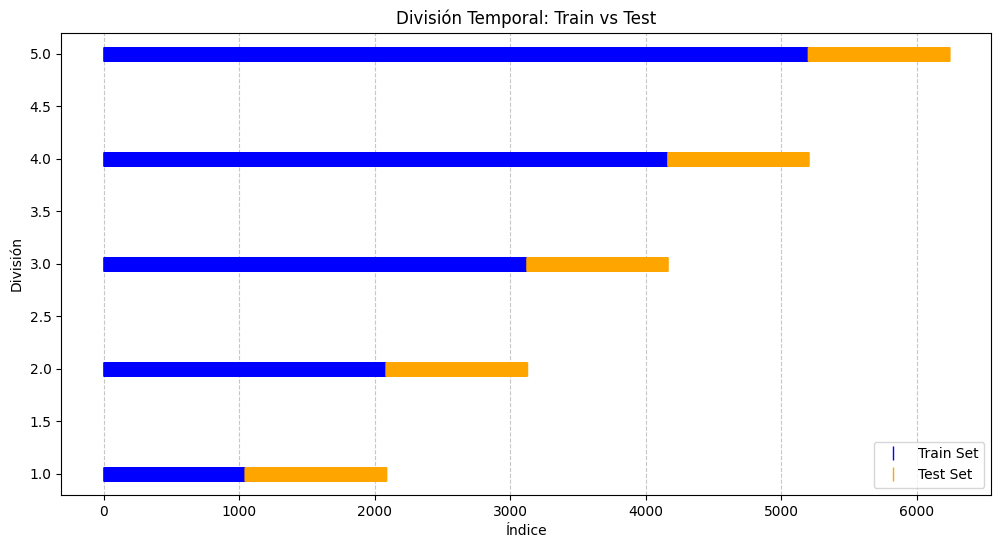

In [50]:
# Crear la figura
plt.figure(figsize=(12, 6))

# Iterar sobre las divisiones
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # Representar el conjunto de entrenamiento
    plt.plot(train_index, [i + 1] * len(train_index), '|', color='blue', label='Train Set' if i == 0 else "", markersize=10)
    # Representar el conjunto de prueba
    plt.plot(test_index, [i + 1] * len(test_index), '|', color='orange', label='Test Set' if i == 0 else "", markersize=10)

# Configurar el gráfico
plt.title("División Temporal: Train vs Test")
plt.xlabel("Índice")
plt.ylabel("División")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

In [51]:
# Obtener la importancia de las características
importances = model.best_estimator_.named_steps['SGDClassifier'].coef_[0]  # Si usas un modelo lineal como SGDClassifier

# Si estás usando un modelo basado en árboles, como RandomForestClassifier:
# importances = model.best_estimator_.named_steps['RandomForestClassifier'].feature_importances_

# Convertir la importancia a un DataFrame para facilitar su visualización
feature_names = X.columns  # Los nombres de las características

# Crear un DataFrame con los nombres de las características y su importancia
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(importance_df)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

ValueError: All arrays must be of the same length

In [49]:
'''# Obtén el transformador MLflowLogger
mlflow_logger = model.best_estimator_.named_steps["MLflowLogger"]

# Registra parámetros y métricas
mlflow_logger.log_params(model.best_params_)
mlflow_logger.log_metrics({"accuracy": model.score(X_test, y_test)})

# Registra el modelo final
mlflow_logger.log_model(model.best_estimator_, model_name="best_model")

# Cierra la ejecución de MLflow
mlflow_logger.close()'''

'# Obtén el transformador MLflowLogger\nmlflow_logger = model.best_estimator_.named_steps["MLflowLogger"]\n\n# Registra parámetros y métricas\nmlflow_logger.log_params(model.best_params_)\nmlflow_logger.log_metrics({"accuracy": model.score(X_test, y_test)})\n\n# Registra el modelo final\nmlflow_logger.log_model(model.best_estimator_, model_name="best_model")\n\n# Cierra la ejecución de MLflow\nmlflow_logger.close()'